# Indices Secundarios en Riak

El objetivo es tener poder recuperar una lista de valores, sin conocer de ante mano la clave del registro.

Sería algo asi como:

```{sql}
select *
from bucket
where campo = valor
```

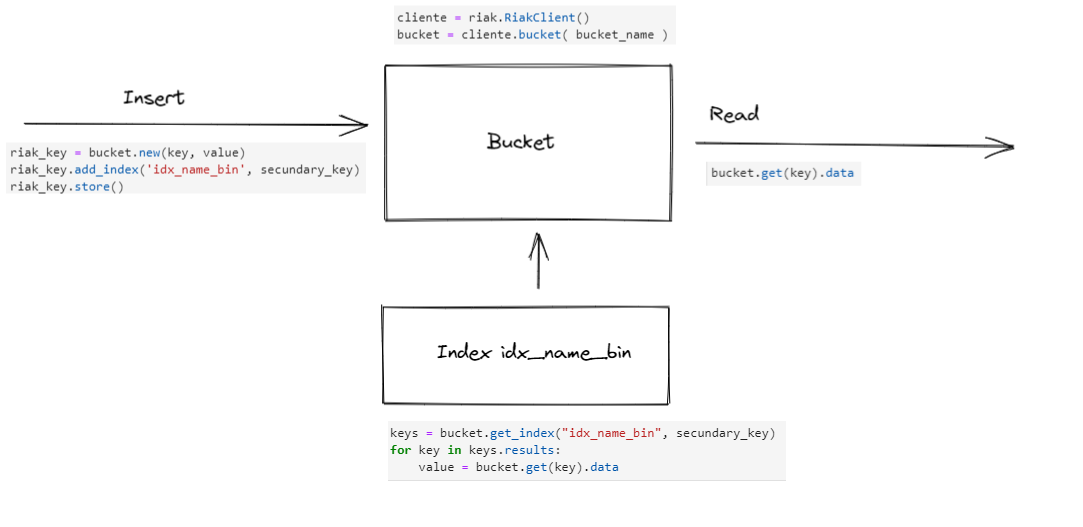## Conexión a Riak

### Conexión a Riak

In [1]:
import riak

In [2]:
cliente = riak.RiakClient()
print("¿Está Riak disponible?", cliente.ping())

¿Está Riak disponible? True


## Escritura en Riak

Vamos a crear un dataset de datos ficticio y lo vamos a cargar en un dataframe de Pandas

In [3]:
from faker import Faker
import pandas as pd
import json

faker = Faker()
Faker.seed(4321)
profiles = []
for i in range(10):
    profile = faker.simple_profile()
    profile['birthdate'] = profile['birthdate'].isoformat()
    profiles.append(profile) 

dataframe = pd.read_json(json.dumps(profiles, default=str))

In [4]:
dataframe

,username,name,sex,address,mail,birthdate
0,daniel02,Robert Duffy,M,"6936 Griffin Extension Suite 018\nSouth Jim, S...",annahamilton@gmail.com,2021-10-31
1,emyers,David Moody,M,"335 Gloria Street Suite 675\nMathisport, NJ 73764",webstermadeline@hotmail.com,1948-06-10
2,fosterroberto,Nicole Jones,F,"84119 Fisher Vista\nEast Cherylton, MS 37193",amandacunningham@yahoo.com,2020-02-18
3,masonnguyen,Scott Lucas,M,"6401 Jeff Ford\nAngelicashire, WV 53209",adam32@hotmail.com,1990-04-02
4,jamie41,Brittany Miller,F,"2871 Mary Ways Apt. 812\nWest Coryhaven, MI 11710",nancy38@yahoo.com,2009-05-07
5,kmartin,Dwayne Miller,M,"56403 Misty Knolls Suite 206\nMartinstad, ID 6...",gregory32@hotmail.com,2017-11-10
6,sarahdawson,Brandon Adams,M,"873 Amber Underpass\nMartinezfurt, AK 85986",joshua01@hotmail.com,1973-06-11
7,andersoncheryl,Ryan Roberts,M,"1210 Juarez Crest Suite 970\nSolisburgh, DC 38745",darrylbanks@yahoo.com,1950-07-15
8,ghardy,Mr. Gary Griffin,M,"65885 Amber Locks Apt. 633\nNorth Steven, ND 0...",brenda14@yahoo.com,1983-01-24
9,jcherry,Andrew Martinez,M,14704 Jennifer Extensions Suite 115\nNorth Ant...,andrewhowell@hotmail.com,1949-04-07


Cada una de las filas del dataset es JSON (diccionario en Python)

In [13]:
profiles[0]

{'username': 'daniel02',
 'name': 'Robert Duffy',
 'sex': 'M',
 'address': '6936 Griffin Extension Suite 018\nSouth Jim, SD 34941',
 'mail': 'annahamilton@gmail.com',
 'birthdate': '2021-10-31'}

In [14]:
print("username:", profiles[0]['username'])
print("ser:", profiles[0]['sex'])
print("mail:", profiles[0]['mail'])

username: daniel02
ser: M
mail: annahamilton@gmail.com


Cargamos la información en Riak en un bucket llamado 'profile'-

Adicionalmente creamos 2 indices, uno por sexo y otro por email.

Los índices secundarios en Riak permiten buscar clavés de una manerá mucho más rápida que si recorrieramos todas las claves de un bucket una tras otra de forma secuencial

Riak exige que el nombre del índice empiece por 'idx' y acabe en 'bin'

In [31]:
bucket = cliente.bucket("bucket_profile")

for value in profiles:
    key = value['username']
    riak_key = bucket.new(key, value)
    riak_key.add_index('idx_mail_bin', value['mail'])
    riak_key.add_index('idx_sex_bin', value['sex'])
    riak_key.store()
    
    print(f"Inserted key: {key}")    
    #print(f"Inserted value: {value}")

Inserted key: daniel02
Inserted key: emyers
Inserted key: fosterroberto
Inserted key: masonnguyen
Inserted key: jamie41
Inserted key: kmartin
Inserted key: sarahdawson
Inserted key: andersoncheryl
Inserted key: ghardy
Inserted key: jcherry


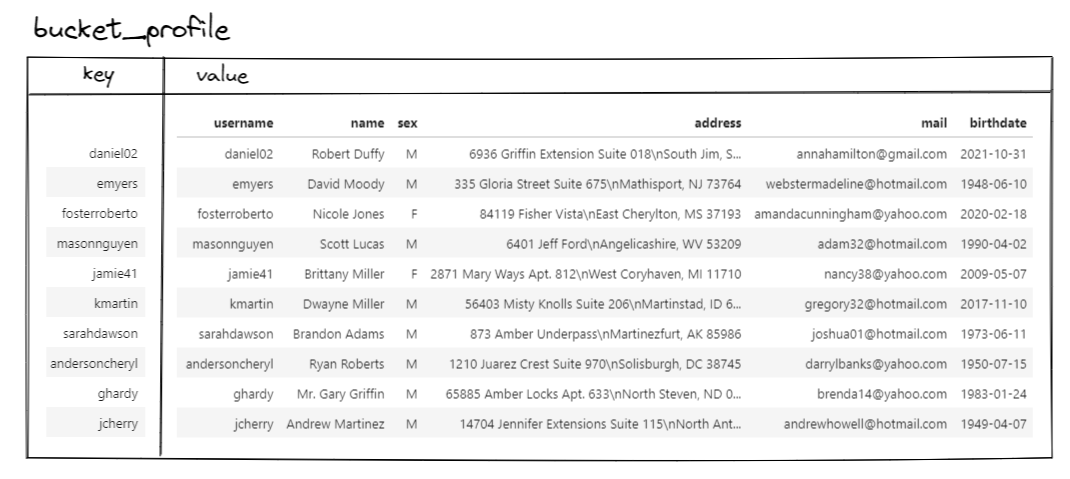

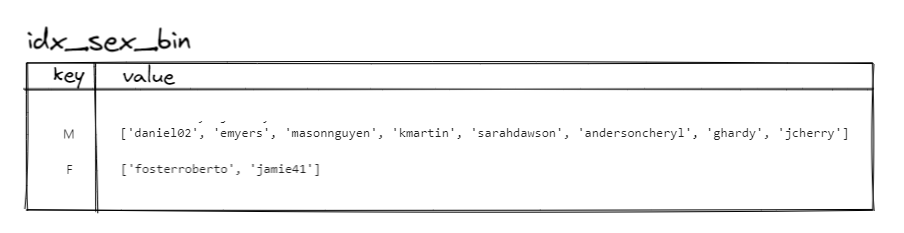

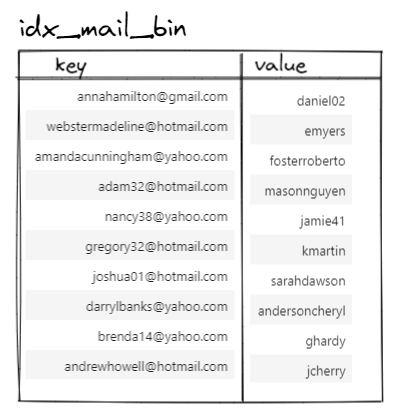

## Lectura

### Lectura a través de la clave del bucket

Podemos acceder al dato directamente a través de la clave ...

```{sql}
SELECT *
FROM profile
where key = 'ghardy'
```

In [28]:
bucket = cliente.bucket("bucket_profile")
profile_json = bucket.get("ghardy").data

rows = [ profile_json ]
pd.read_json(json.dumps(rows))

,username,name,sex,address,mail,birthdate
0,ghardy,Mr. Gary Griffin,M,"65885 Amber Locks Apt. 633\nNorth Steven, ND 0...",brenda14@yahoo.com,1983-01-24


### Lectura a través del ínidice secundario

Ahora vamos a localizar las claves del sexo "M" a través del ínidice

```{sql}
SELECT *
FROM profile
WHERE sex = 'F'
```

In [23]:
rows = []
bucket = cliente.bucket("bucket_profile")
keys = bucket.get_index("idx_sex_bin", 'F')
for key in keys.results:
    profile_json = bucket.get(key).data
    print(f"Key Recovered: {key}")
    rows.append(profile_json)   
       
df = pd.read_json(json.dumps(rows))

Key Recovered: fosterroberto
Key Recovered: jamie41


In [24]:
df

,username,name,sex,address,mail,birthdate
0,fosterroberto,Nicole Jones,F,"84119 Fisher Vista\nEast Cherylton, MS 37193",amandacunningham@yahoo.com,2020-02-18
1,jamie41,Brittany Miller,F,"2871 Mary Ways Apt. 812\nWest Coryhaven, MI 11710",nancy38@yahoo.com,2009-05-07


Ahora vamos a localizar las claves del mail "joshua01@hotmail.com" a través del ínidice

```{sql}
SELECT *
FROM profile
WHERE mail = 'joshua01@hotmail.com'
```

In [25]:
rows = []
bucket = cliente.bucket("bucket_profile")
keys = bucket.get_index("idx_mail_bin", 'joshua01@hotmail.com')
for key in keys.results:
    profile_json = bucket.get(key).data    
    print(f"Key Recovered: {key}")
    rows.append(profile_json)
       
df = pd.read_json(json.dumps(rows))

Key Recovered: sarahdawson


In [26]:
df

,username,name,sex,address,mail,birthdate
0,sarahdawson,Brandon Adams,M,"873 Amber Underpass\nMartinezfurt, AK 85986",joshua01@hotmail.com,1973-06-11
